### This notebook takes in csv dataset of household load consumption and PV generation data to perform the following:
- Generates and plots heatmap of RMSE and MAPE values 

In [2]:
import nbimporter
from Functions import Functions
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import numpy as np
from IFEEL import ifeel_transformation, ifeel_extraction
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
import seaborn as sns
import random

In [9]:
# Import dataset of both household and PV data 
df = pd.read_csv (r"C:\Users\tangl\OneDrive\Engineering Course\Year 4\4YP Lingxi Tang\Load + PV Dataset.csv",parse_dates=['date_time'],dayfirst=True)
df_test = pd.read_csv(r"C:\Users\tangl\OneDrive\Engineering Course\Year 4\4YP\IFEEL_test_data_1month_30mins.csv", header=0,index_col=0, parse_dates=False)


pv_col = 3                                                       # No. of columns of PV generation data
hh_col = 81                                                     # No. of columns of household load data


df = df.sort_values("date_time")
df.iloc[:,-pv_col:] = -df.iloc[:,-pv_col:]                       # Change PV generation data to negative
date_time = df.iloc[:,0]
df.drop(columns=df.columns[0], 
        axis=1, 
        inplace=True)


# Separate household load and PV generation data 
pv_df = df.iloc[:,-pv_col:]
hh_df_1 = df.iloc[:,:hh_col]
hh_df_2 = df.iloc[:,hh_col:hh_col*2]

In [16]:
df_test = pd.read_csv(r"C:\Users\tangl\OneDrive\Engineering Course\Year 4\4YP\IFEEL_test_data_1month_30mins.csv", header=0,index_col=0, parse_dates=False)
all_all_rmse = np.zeros((7,21))
all_all_mape = np.zeros((7,20))

repetitions = 5



for i in range(repetitions):
    all_row_rmse = []
    all_row_mape = []
    random.seed(i)
    ## Generate annual net load curve and extract IFEEL features 
    for no_of_houses in range(20,81,10):
        for no_of_pv in range(no_of_houses+1):
            pv_pen_rate = no_of_pv/no_of_houses
            remainder_pv_no = no_of_pv%3
            whole_pv_no = no_of_pv - remainder_pv_no
            total_pv_generated = pv_df.sum(axis = 1) * whole_pv_no / no_of_houses
            if remainder_pv_no == 1 or remainder_pv_no == 2:
                more_pv = pv_df.iloc[:,0]
                more_pv = more_pv/56
                total_pv_generated = total_pv_generated + more_pv

            if remainder_pv_no == 2:
                more_pv = pv_df.iloc[:,1]
                more_pv = more_pv/56
                total_pv_generated = total_pv_generated + more_pv
                
            randomlist = random.sample(range(81), no_of_houses)
        
            hh_df = hh_df_1.iloc[:,randomlist]
            feeder_load = hh_df.sum(axis = 1) + total_pv_generated 
            pv_capacity = no_of_pv * 4.6       # pv capacity in kWp
            all_data = Functions.obtaincluster(feeder_load,pv_capacity,date_time)
            feat = Functions.get_IFEEL_feats(all_data,df_test,True)
            if no_of_pv == 0: 
                all_feat = feat
            if no_of_pv != 0:
                all_feat = all_feat.append(feat)

            # Extract second batch of feeder load data to add to training set 
            hh_df = hh_df_2.iloc[:,randomlist]
            feeder_load = hh_df.sum(axis = 1) + total_pv_generated 
            pv_capacity = no_of_pv * 4.6       # pv capacity in kWp
            all_data = Functions.obtaincluster(feeder_load,pv_capacity,date_time)
            feat = Functions.get_IFEEL_feats(all_data,df_test,True)
            all_feat = all_feat.append(feat)

        df = all_feat.drop(all_feat.columns[[14,15,16,17,18,19,20]],axis = 1)
        
        X = df.iloc[:,:16]    
        Y = df.iloc[:,-1:]
        X = X.to_numpy()
        Y = Y.to_numpy()

        (X_train, X_test, y_train, y_test,) = train_test_split(X, Y,stratify = Y, test_size=0.1)
        

        ### Activate code below to select samples based on season
        #season = 3                                      # Change number based on desired season: Summer - 1, Winter - 2, Transition - 3
        #y_train = y_train[X_train[:, 14] == season]
        #y_test = y_test[X_test[:, 14] == season]
        #X_train = X_train[X_train[:, 14] == season, :]   
        #X_test = X_test[X_test[:, 14] == season, :]

        ## Remove season feature
        #X_train = np.delete(X_train,-2,axis=1)
        #X_test = np.delete(X_test,-2,axis=1)

        
        ### Activate code below to select samples based on intra-week group
        #weekgroup = 3                                      # Change number based on desired intra-week group, Mon - Thurs: 1, Fri-Sat: 2, Sun: 3
        #y_train = y_train[X_train[:, 15] == weekgroup]
        #y_test = y_test[X_test[:, 15] == weekgroup]
        #X_train = X_train[X_train[:, 15] == weekgroup, :]   
        #X_test = X_test[X_test[:, 15] == weekgroup, :]

        ## Remove intra-week group feature
        #X_train = np.delete(X_train,-1,axis=1)
        #X_test = np.delete(X_test,-1,axis=1)
        
        y_test = np.ravel(y_test)
        y_train = np.ravel(y_train)
        sc_X = preprocessing.StandardScaler()
        X_train=sc_X.fit_transform(X_train)
        X_test=sc_X.transform(X_test)
        regr = MLPRegressor(hidden_layer_sizes = (270,270), max_iter=220, learning_rate_init = 0.01, alpha = 0.0005).fit(X_train, y_train)
        results = regr.predict(X_test)
        combined = np.vstack((y_test, results)).T
        y_values_by_x = {}
        for x, y in combined:
            y_values_by_x.setdefault(x, []).append(y)
        
        ## Code below for RMSE
        mse = {k: sum((k-v)**2)/len(v) for k, v in y_values_by_x.items()}
        rmse = {k: math.sqrt(v) for k, v in mse.items()}
        
        all_rmse = np.array(list(rmse.items()))
        all_rmse[:,0] =all_rmse[:,0]/4.6
        all_rmse[:,0] = all_rmse[:,0]/no_of_houses                        # % households with PV installed, rmse

        row_rmse = []
        for pv_percentage in range(0,101,5):
            index_min = np.argmin(abs(all_rmse[:,0] - pv_percentage/100))
            error = all_rmse[index_min][1]
            row_rmse.append(error)
        all_row_rmse.append(row_rmse)
            
        ## Code below for MAPE
        mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}
    
        all_mape = np.array(list(mape.items()))
        all_mape[:,0] =all_mape[:,0]/4.6
        all_mape[:,0] = all_mape[:,0]/no_of_houses                        # % households with PV installed, rmse
        
        row_mape = []
        for pv_percentage in range(5,101,5):
            index_min = np.argmin(abs(all_rmse[:,0] - pv_percentage/100))
            error = all_mape[index_min][1]
            row_mape.append(error)
        all_row_mape.append(row_mape)
        
    all_all_rmse = np.add(all_all_rmse,all_row_rmse)
    all_all_mape = np.add(all_all_mape,all_row_mape)
    print(i)
all_all_rmse = np.divide(all_all_rmse,repetitions) 
all_all_mape = np.divide(all_all_mape,repetitions)

C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}
C:\Users\tangl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (220) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}
C:\Users\tangl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (220) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: s

0


C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}
C:\Users\tangl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (220) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}
C:\Users\tangl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (220) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: s

1


C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}
C:\Users\tangl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (220) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}
C:\Users\tangl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (220) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: s

2


C:\Users\tangl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (220) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}
C:\Users\tangl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (220) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}
C:\Users\tangl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: 

3


C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}
C:\Users\tangl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (220) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}
C:\Users\tangl\miniconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (220) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: s

4


C:\Users\tangl\AppData\Local\Temp/ipykernel_9532/4020353443.py:109: RuntimeWarning: divide by zero encountered in true_divide
  mape = {k: sum(abs(k-v)/k)/len(v) for k, v in y_values_by_x.items()}


In [17]:
### Save npy file of rmse values
np.save('ave_81hh_all_rmse',all_all_rmse)
np.save('ave_81hh_all_mape',all_all_mape)

### Plot RMSE heatmap changing with number of households and PV penetration rate

In [106]:
all_all_error = np.load('ave_81hh_all_mape.npy')

Text(0.5, 1.0, 'All Data')

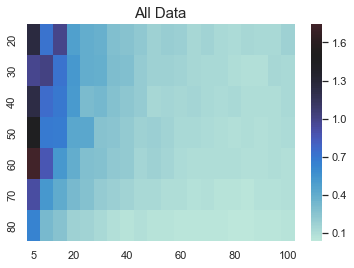

In [112]:
x_axis_labels = [5,'','',20,'','','',40,'','','',60,'','','',80,'','','',100]
y_axis_labels = [x for x in range(20,81,10)] # %%latexbels for y-axis
sns.set(rc = {'figure.figsize':(6,4)})
s = sns.heatmap(all_all_error, xticklabels=x_axis_labels, yticklabels=y_axis_labels,cbar=True,center = 1.5,cbar_kws={'ticks': [0.1,0.4,0.7,1,1.3,1.6]})
s.set_title('All Data',fontsize=15)
#s.set_xlabel('Percentage of properties with installed PV (%)', fontsize=13)
#s.set_ylabel('Number of properties', fontsize=20)